# Peatland Breathing Analysis – Murnauer Moos

## Objective
- Analyze peatland condition using multi-source remote sensing data:
  - **Sentinel-1 radar VH/VV ratio** (vegetation and moisture dynamics)
  - **InSAR displacement** (surface deformation related to peatland subsidence or swelling)
  - **Sentinel-2 NDVI** (vegetation greenness and health)
  - **Rainfall data** (precipitation impact on hydrology and vegetation)
- Study temporal dynamics (monthly aggregation) and investigate **lagged effects of rainfall on vegetation, moisture, and surface displacement**.
- Visualize time series and spatial patterns, map sample points, and compute correlation tests among all variables to understand peatland “breathing” behavior (expansion/contraction cycles).



In [8]:
# 1. Import Libraries and Initialize Earth Engine

# Earth Engine and geospatial libraries
import ee
import geemap
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rioxarray as rxr

# Data handling and computation
import pandas as pd
import numpy as np
import os
import glob

# Statistics and plotting
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates



# Initialize Google Earth Engine
ee.Initialize()


In [9]:
# 2. Load peatland shapefile 
peatland_path = r"C:\Users\fyeqa\OneDrive\Documents\Github\New-project\WDPA_WDOECM_Sep2025_Public_555522240_shp\WDPA_WDOECM_Sep2025_Public_555522240_shp_0\WDPA_WDOECM_Sep2025_Public_555522240_shp-polygons.shp"
peatland = gpd.read_file(peatland_path)

# Define time range for analysis
start_date = '2023-01-01'
end_date = '2023-12-31'

# Convert geopandas GeoDataFrame to GeoJSON format for Earth Engine
geojson = peatland.__geo_interface__
peatland_ee = ee.FeatureCollection(geojson)

# Initialize interactive map centered near peatland (latitude, longitude)
Map = geemap.Map(center=[47.645, 11.179], zoom=12)

# Add peatland polygons layer with styling
Map.addLayer(peatland_ee.style(color='yellow'), {}, 'Peatland Polygons')

# Display the map
Map

Map(center=[47.645, 11.179], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [16]:
# 3. Insar Displacement
data_folder = r"C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data" # Folder where your files are stored
wavelength = 0.056  # Sentinel-1 wavelength in meters
coh_threshold = 0.3
# Prepare lists to store results
months = []
mean_displacements = []

In [27]:

# Sentinel-1 wavelength in meters
wavelength = 0.056

# Path to your displacement/coherence files folder
data_folder = r"C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data"

# Load your peatland shapefile (make sure you load it before this code!)
# peatland = gpd.read_file("path_to_your_peatland_shapefile.shp")

# List all displacement files
unw_files = sorted(glob.glob(os.path.join(data_folder, "*.geo.unw.tif")))

displacement_records = []

for file in unw_files:
    print(f"\nProcessing file: {file}")
    try:
        basename = os.path.basename(file)
        dates_part = basename.split(".")[0]
        start_str, end_str = dates_part.split("_")
        start_date = pd.to_datetime(start_str, format="%Y%m%d")
        end_date = pd.to_datetime(end_str, format="%Y%m%d")

        # Open displacement raster
        unw = rxr.open_rasterio(file, masked=True).squeeze()
        print(f"Loaded displacement raster.")

        # Construct coherence filename (replace .unw.tif with .cc.tif)
        coh_file = file.replace(".unw.tif", ".cc.tif")
        if not os.path.exists(coh_file):
            print(f"⚠️ Coherence file not found: {coh_file}, skipping.")
            continue

        coh = rxr.open_rasterio(coh_file, masked=True).squeeze()
        print(f"Loaded coherence raster.")

        # Normalize coherence if needed
        if coh.max() > 1:
            coh = coh / 255.0

        # Reproject peatland shapefile to raster CRS
        peatland_proj = peatland.to_crs(unw.rio.crs)

        # Clip displacement and coherence to peatland boundary
        unw_clip = unw.rio.clip(peatland_proj.geometry, peatland_proj.crs, drop=True)
        coh_clip = coh.rio.clip(peatland_proj.geometry, peatland_proj.crs, drop=True)

        # Mask displacement where coherence is below threshold
        coh_mask = coh_clip > 0.3
        unw_masked = unw_clip.where(coh_mask)

        # Convert phase displacement to meters
        displacement_m = (unw_masked * wavelength) / (4 * np.pi)
        print("Peatland CRS:", peatland.crs)
        print("Raster CRS:", unw.rio.crs)


        # Calculate displacement statistics
        mean_disp = float(displacement_m.mean().values)
        max_disp = float(displacement_m.max().values)
        min_disp = float(displacement_m.min().values)

        displacement_records.append({
            "date_range": f"{start_str}_{end_str}",
            "start_date": start_date,
            "end_date": end_date,
            "mean_displacement_m": mean_disp,
            "max_displacement_m": max_disp,
            "min_displacement_m": min_disp
        })

        print(f"Processed displacement for {start_str} to {end_str}")

    except Exception as e:
        print(f"⚠️ Error processing {file}: {e}")

# Create DataFrame and sort by start_date
displacement_df = pd.DataFrame(displacement_records).sort_values("start_date").reset_index(drop=True)

displacement_df

displacement_df['month'] = displacement_df['start_date'].dt.month
displacement_df['month_name'] = displacement_df['start_date'].dt.strftime('%B')



Processing file: C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data\20230111_20230123.geo.unw.tif
Loaded displacement raster.
Loaded coherence raster.
Peatland CRS: EPSG:4326
Raster CRS: EPSG:4326
⚠️ Error processing C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data\20230111_20230123.geo.unw.tif: zero-size array to reduction operation fmax which has no identity

Processing file: C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data\20230111_20230216.geo.unw.tif
Loaded displacement raster.
Loaded coherence raster.
Peatland CRS: EPSG:4326
Raster CRS: EPSG:4326
⚠️ Error processing C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data\20230111_20230216.geo.unw.tif: zero-size array to reduction operation fmax which has no identity

Processing file: C:\Users\fyeqa\OneDrive\Documents\Github\New-project\Data\20230216_20230228.geo.unw.tif
Loaded displacement raster.
Loaded coherence raster.
Peatland CRS: EPSG:4326
Raster CRS: EPSG:4326
⚠️ Error processing C:\Users\fyeqa\

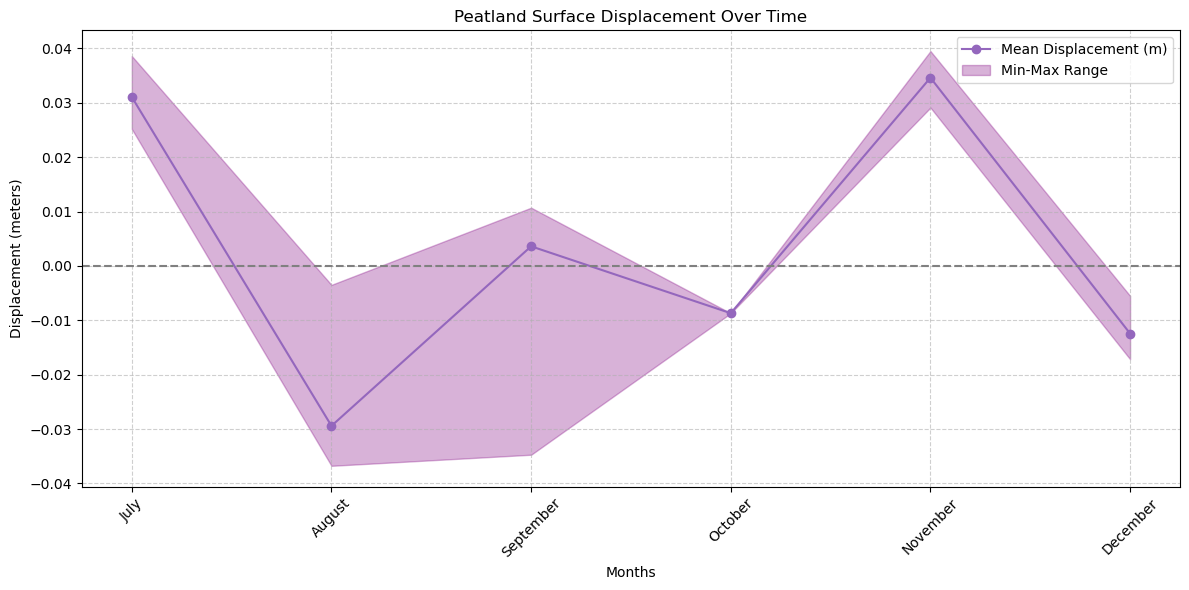

In [28]:
# Optional: Plot time series of mean displacement
plt.figure(figsize=(12, 6))
plt.plot(displacement_df['month_name'], displacement_df['mean_displacement_m'], marker='o', color='tab:purple', label='Mean Displacement (m)')
plt.fill_between(displacement_df['month_name'],
                 displacement_df['min_displacement_m'],
                 displacement_df['max_displacement_m'],
                 color='purple', alpha=0.3, label='Min-Max Range')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Peatland Surface Displacement Over Time")
plt.xlabel("Months")
plt.ylabel("Displacement (meters)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# 3: Sentinel-1 ImageCollection filtered over peatland_ee
s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filterBounds(peatland_ee)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .select(['VV', 'VH']))

# Function to compute VH/VV ratio and its dB value
def compute_ratio(img):
    ratio = img.select('VH').divide(img.select('VV')).rename('VH_VV_ratio')
    ratio_dB = ratio.log10().multiply(10).rename('VH_VV_dB')
    return img.addBands([ratio, ratio_dB])

s1_ratio = s1.map(compute_ratio)

# Function to extract mean VH/VV dB over peatland for each image
def extract_mean(img):
    mean_dict = img.select('VH_VV_dB').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=peatland_ee.geometry(),  # Use geometry for reduceRegion
        scale=20,
        maxPixels=1e9
    )
    mean_val = mean_dict.get('VH_VV_dB')
    date = img.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'VH_VV_dB': mean_val})

s1_fc = s1_ratio.map(extract_mean)

# Get lists of dates and values (this triggers the server call)
dates = s1_fc.aggregate_array('date').getInfo()
values = s1_fc.aggregate_array('VH_VV_dB').getInfo()

# Create pandas DataFrame
s1_df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'VH_VV_dB': values
})

In [12]:
# Sentinel-2 NDVI Calculation 
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(peatland_ee)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
      .map(lambda img: img.normalizedDifference(['B8', 'B4'])
                      .rename('NDVI')
                      .copyProperties(img, ['system:time_start'])))

# MODIS NDVI collection
ndvi_modis = (ee.ImageCollection('MODIS/061/MOD13Q1')
              .filterDate(start_date, end_date)
              .filterBounds(peatland_ee)
              .select('NDVI'))

# Extract mean NDVI from MODIS scaled by 0.0001
def extract_ndvi(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=peatland_ee.geometry(),
        scale=250,
        maxPixels=1e9
    )
    mean_val = ee.Number(mean_dict.get('NDVI')).multiply(0.0001)
    date = img.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'ndvi': mean_val})

ndvi_fc = ndvi_modis.map(extract_ndvi)

# Convert to Pandas DataFrame
ndvi_dates = ndvi_fc.aggregate_array('date').getInfo()
ndvi_values = ndvi_fc.aggregate_array('ndvi').getInfo()

ndvi_df = pd.DataFrame({
    'date': pd.to_datetime(ndvi_dates),
    'ndvi': ndvi_values
})

In [13]:
# Rainfall Data (ERA5-Land daily total precipitation) 
era5 = (ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
        .filterBounds(peatland_ee)
        .filterDate(start_date, end_date)
        .select('total_precipitation_sum'))

def convert_rain(img):
    mm = img.select('total_precipitation_sum').multiply(1000).rename('rain_mm')
    return mm.copyProperties(img, ['system:time_start'])

rain_mm = era5.map(convert_rain)

# CHIRPS rainfall data
chirps = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
         .filterDate(start_date, end_date)
         .filterBounds(peatland_ee))

def extract_rain(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=peatland_ee.geometry(),
        scale=5000,
        maxPixels=1e9
    )
    mean_val = mean_dict.get('precipitation')
    date = img.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'rain_mm': mean_val})

rain_fc = chirps.map(extract_rain)

# Convert to Pandas DataFrame
rain_dates = rain_fc.aggregate_array('date').getInfo()
rain_values = rain_fc.aggregate_array('rain_mm').getInfo()

rain_df = pd.DataFrame({
    'date': pd.to_datetime(rain_dates),
    'rain_mm': rain_values
})

In [14]:
# Convert 'date' columns to datetime and set as index
s1_df['date'] = pd.to_datetime(s1_df['date'])
s1_df.set_index('date', inplace=True)

ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df.set_index('date', inplace=True)

rain_df['date'] = pd.to_datetime(rain_df['date'])
rain_df.set_index('date', inplace=True)

# Resample to monthly frequency
# For Sentinel-1 and NDVI: take monthly mean
s1_monthly = s1_df.resample('M').mean().reset_index()
ndvi_monthly = ndvi_df.resample('M').mean().reset_index()

# For Rainfall: sum monthly precipitation
rain_monthly = rain_df.resample('M').sum().reset_index()

# Merge all monthly dataframes on 'date'
merged_monthly = pd.merge(s1_monthly, ndvi_monthly, on='date', how='outer')
merged_monthly = pd.merge(merged_monthly, rain_monthly, on='date', how='outer')

# Sort by date and reset index
merged_monthly = merged_monthly.sort_values('date').reset_index(drop=True)

merged_monthly

,date,VH_VV_dB,ndvi,rain_mm
0,2023-01-31,1.865210,0.356432,59.776153
1,2023-02-28,1.917734,0.476238,35.795095
2,2023-03-31,2.019428,0.482533,89.706287
3,2023-04-30,1.925862,0.566434,118.890551
4,2023-05-31,2.116596,0.724273,138.782220
5,2023-06-30,1.884670,0.799935,72.734310
6,2023-07-31,2.035295,0.795121,158.230200
7,2023-08-31,2.036199,0.780139,242.562725
8,2023-09-30,2.047745,0.722540,74.567047
9,2023-10-31,1.984120,0.688498,74.438394


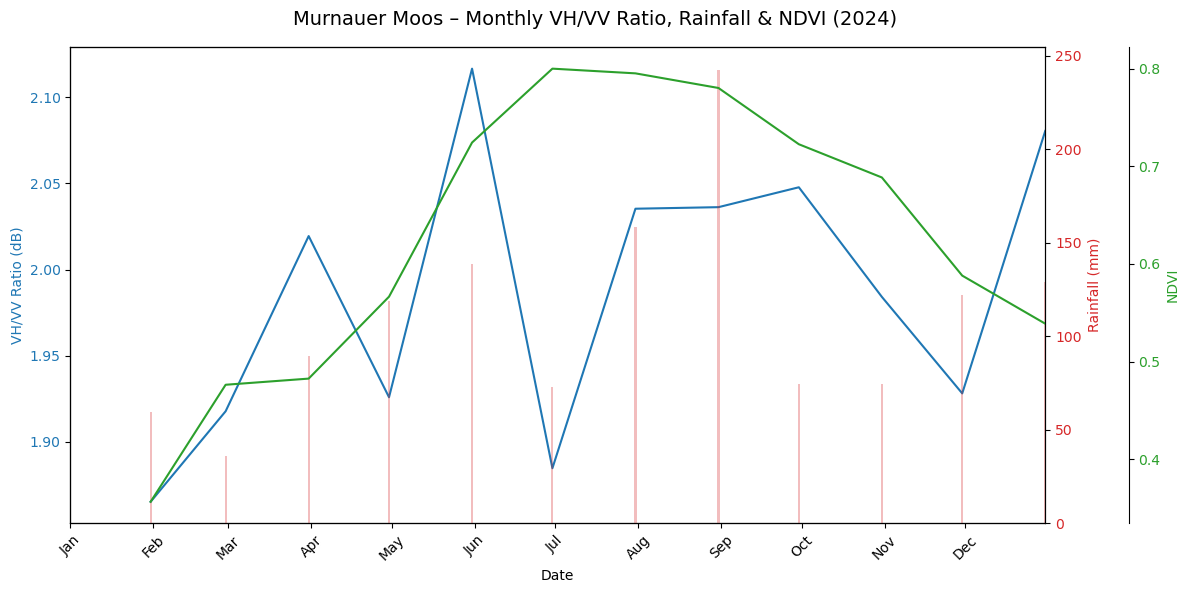

In [52]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(merged_monthly['date'], merged_monthly['VH_VV_dB'], color='tab:blue', label='VH/VV Ratio (dB)')
ax1.set_xlabel("Date")
ax1.set_ylabel("VH/VV Ratio (dB)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.bar(merged_monthly['date'], merged_monthly['rain_mm'], color='tab:red', alpha=0.3, label='Rainfall (mm)')
ax2.set_ylabel("Rainfall (mm)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(merged_monthly['date'], merged_monthly['ndvi'], color='tab:green', label='NDVI')
ax3.set_ylabel("NDVI", color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Set explicit x-axis limits to start Jan 1 and end Dec 31 of the year(s) in your data
start_date = pd.to_datetime(f'{merged_monthly["date"].dt.year.min()}-01-01')
end_date = pd.to_datetime(f'{merged_monthly["date"].dt.year.max()}-12-31')
ax1.set_xlim(start_date, end_date)

# Set major ticks to the 1st day of each month
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Rotate month labels for clarity
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

fig.suptitle("Murnauer Moos – Monthly VH/VV Ratio, Rainfall & NDVI (2024)", fontsize=14)
fig.tight_layout()
plt.show()
